In [64]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

import xgboost as xgb
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

import warnings
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# pip install geopandas

In [3]:
def get_train_test(df, test_size, condition="backscatter"):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    if(condition=="backscatter"):
        X = df.loc[:,'VH_30':'VH_0']
        X['nth'] = df.loc[:,'nth']
        # X = df.loc[:,'VH_10':'VH_0']
    elif(condition=="features"):
        X = df.loc[:,'F1':'F17']
    elif(condition=="all"):
        X = df.loc[:,'VH_0':'F17']
    else: 
        print("set the condition")
        return None
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
from collections import Counter
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 2
    class_2_mask = (y_true == 2)
    if np.any(class_2_mask):  # Check if class 2 is present in the true labels
        return accuracy_score(y_true[class_2_mask], y_pred[class_2_mask])
    else:
        return 0.0  # Return 0 if class 2 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 0, 1, 2, and 3
    class_0123_mask = (y_true >= 0) & (y_true <= 3)
    if np.any(class_0123_mask):  # Check if classes 0, 1, 2, or 3 are present in the true labels
        return accuracy_score(y_true[class_0123_mask], y_pred[class_0123_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

def evaluate_model(X_train, y_train, X_test, y_test, best_params=None, n_splits=5):
    # Convert data to DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    if best_params is None:
        params = {
            "objective": "multi:softprob",  # or "multi:softmax" if you want the class labels directly
            "eval_metric": ['mlogloss'],
            "num_class": len(set(y_train)),  # Number of classes in the target variable
            "max_depth": 8,
            'reg_lambda':2,
            "learning_rate": 0.1,
            "verbosity": 1, 
            "nthread": 8,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
        }
    else:
        print("Best parameters: " + str(best_params))
        params = {
            "objective": "multi:softprob",  # Use softprob to get probabilities for each class
            "eval_metric": ['mlogloss'],  # Evaluation metrics
            "num_class": len(set(y_train)),  # Number of classes
            "nthread": 8,
            **best_params  # Unpack the best parameters from Optuna
        }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        model = xgb.train(params, dtrain_fold, num_boost_round=1000)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    # Final model evaluation on the test set
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[0, 0:2]) + sum(cm[0, 4:5]) + sum(cm[1, 0:3]) + sum(cm[2, 1:4]) + sum(cm[3, 2:5]) + sum(cm[4, 3:5]) + sum(cm[4, 0:1])) / sum(sum(cm[0:5, 0:5]))

    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

In [5]:
## Read VH dataset
kdprov='32'
# df=pd.read_pickle('/data/ksa/04_Data_Preprocessing/32/03_som_filtering/data_with_prior_posterior.pkl').query('prior>=0.5')
df=pd.read_pickle('/data/ksa/04_Data_Preprocessing/training-test/32/training_32_VH_recode2_imputation_var10_clusternV2.pkl')#.query('prior>=0.5')
print(df.shape)
df.head()

(630850, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_3,VH_2,VH_1,VH_0,year,date,cluster_data,Sigma0VH_variance,observation2,flag_variance_Q10
0,320201009C1#01,320201009C1,320201009,1,2022_03,G,48MXS,-14.566465,-14.238100,-15.280122,...,-14.220155,-14.081954,-15.385819,-14.512360,22,2022-01-01,4,0.245499,3,1
1,320201009C1#02,320201009C1,320201009,1,2022_03,G,48MXS,-14.742791,-14.646698,-14.321390,...,-14.035186,-14.236593,-14.159606,-13.999538,22,2022-01-01,4,0.245499,3,1
2,320201009C1#03,320201009C1,320201009,1,2022_03,G,48MXS,-14.617775,-14.604097,-14.519908,...,-14.464883,-14.530542,-12.912482,-13.230688,22,2022-01-01,4,0.245499,3,1
3,320201009C1#04,320201009C1,320201009,1,2022_03,G,48MXS,-14.936208,-15.204391,-15.527640,...,-15.474051,-14.226636,-14.716984,-14.031856,22,2022-01-01,4,0.245499,3,1
4,320201009C1#05,320201009C1,320201009,1,2022_03,G,48MXS,-14.224077,-14.520339,-14.856548,...,-13.071113,-13.265615,-13.770346,-13.552280,22,2022-01-01,4,0.245499,3,1


In [6]:
conditions = {
    'V1':1,
    'V2':2,
    'G':3,
    'H':4,
    'BP':0,
    'PL':5,
    'BPL':0,
    'NP':7,
    'NV':7
}

# Mapping values in 'column_name'
df['obs_ste'] = df['observation']
df['observation'] = df['obs_ste'].map(conditions)

In [7]:
# df['observation'].unique()

/tmp/ipykernel_35797/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

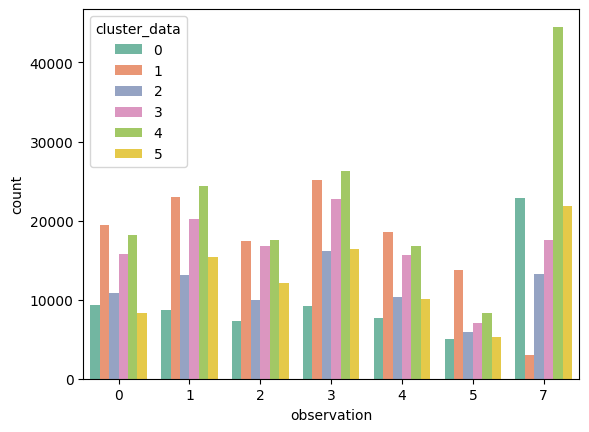

In [8]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

In [9]:
# df_sampled = df.groupby(['observation','cluster_data'], group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))
# df_sampled

### Running Data

CLUSTER:  0


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 0 5 1 2 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      2805
           1       0.88      0.80      0.84      2603
           2       0.79      0.74      0.76      2190
           3       0.80      0.75      0.77      2768
           4       0.78      0.73      0.75      2287
           5       0.87      0.71      0.78      1500
           6       0.73      0.91      0.81      6840

    accuracy                           0.78     20993
   macro avg       0.81      0.75      0.77     20993
weighted avg       0.79      0.78      0.78     20993



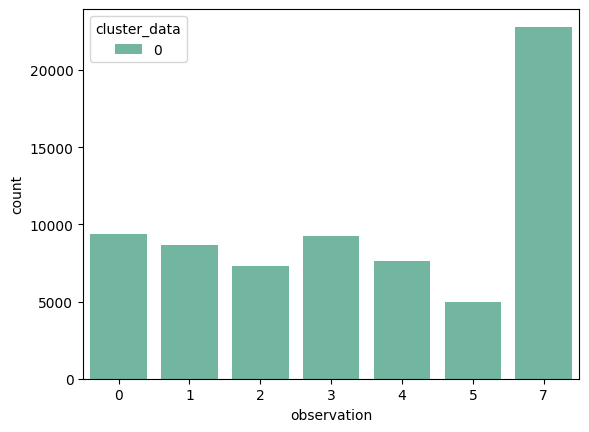

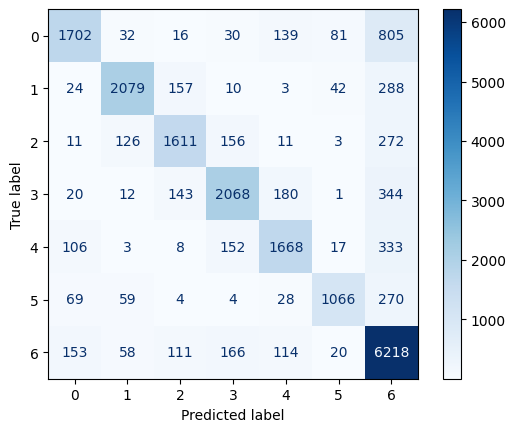

{'average_accuracy': 0.7785922707899724, 'average_f1_macro': np.float64(0.7691550969059439), 'average_f1_micro': np.float64(0.7785922707899724), 'average_auc': np.float64(0.9530224156129498), 'average_acc_kelas_generatif': 0.7268101761252446, 'average_acc_fase_padi': 0.714811378652936}
{'val_accuracy': 0.7817844043252513, 'val_f1_macro': np.float64(0.7725597630071555), 'val_f1_micro': np.float64(0.7817844043252513), 'val_auc': np.float64(0.9546172343629621), 'val_acc_kelas_generatif': 0.7356164383561644, 'val_acc_fase_padi': 0.7196604283233649, 'val_relative_acc': np.float64(98.81532435272761)}
CLUSTER:  1


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 0 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5850
           1       0.94      0.92      0.93      6885
           2       0.86      0.88      0.87      5220
           3       0.89      0.90      0.89      7553
           4       0.86      0.88      0.87      5573
           5       0.91      0.89      0.90      4117
           6       0.60      0.51      0.55       915

    accuracy                           0.88     36113
   macro avg       0.85      0.84      0.84     36113
weighted avg       0.88      0.88      0.88     36113



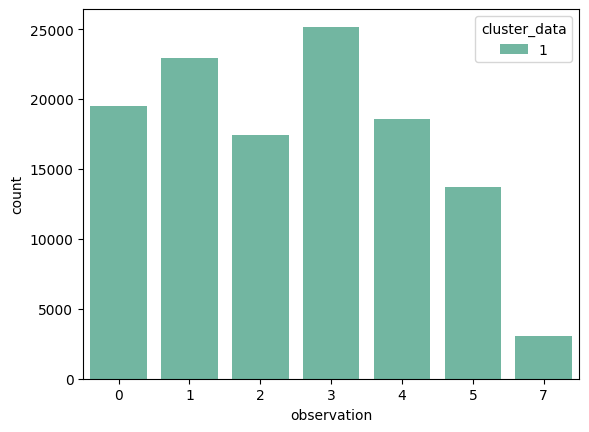

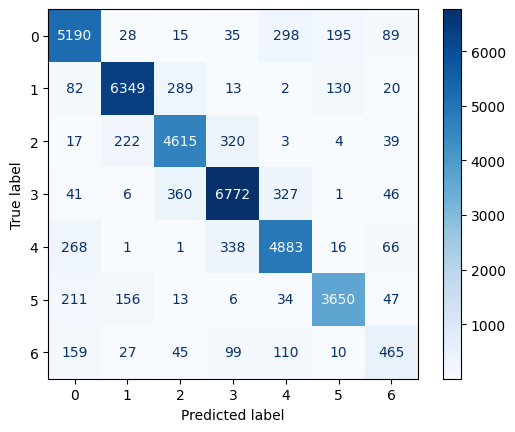

{'average_accuracy': 0.8840995965603016, 'average_f1_macro': np.float64(0.848087289704953), 'average_f1_micro': np.float64(0.8840995965603016), 'average_auc': np.float64(0.9891402657079954), 'average_acc_kelas_generatif': 0.8838259441707716, 'average_acc_fase_padi': 0.8990540597992374}
{'val_accuracy': 0.8840029906127987, 'val_f1_macro': np.float64(0.8422251255929105), 'val_f1_micro': np.float64(0.8840029906127987), 'val_auc': np.float64(0.9892425010103177), 'val_acc_kelas_generatif': 0.8840996168582376, 'val_acc_fase_padi': 0.8987768543202133, 'val_relative_acc': np.float64(99.56029532403609)}
CLUSTER:  2


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[2 5 4 7 3 1 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      3247
           1       0.80      0.76      0.78      3922
           2       0.77      0.74      0.76      2978
           3       0.83      0.81      0.82      4860
           4       0.74      0.75      0.74      3120
           5       0.73      0.61      0.66      1770
           6       0.61      0.73      0.66      3968

    accuracy                           0.75     23865
   macro avg       0.75      0.73      0.74     23865
weighted avg       0.75      0.75      0.75     23865



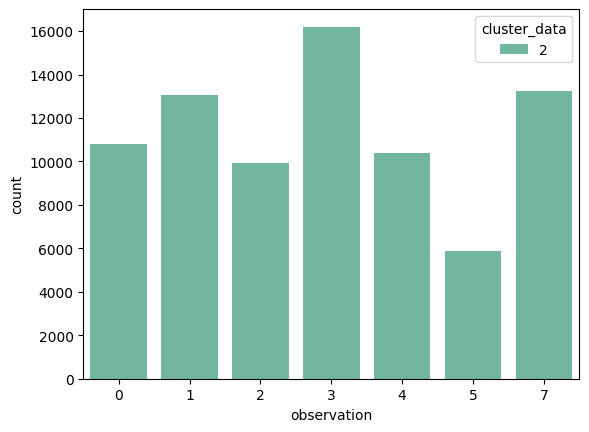

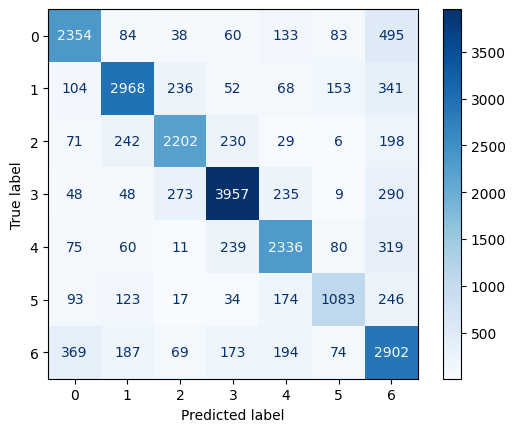

{'average_accuracy': 0.7494298284995959, 'average_f1_macro': np.float64(0.7419337246422454), 'average_f1_micro': np.float64(0.7494298284995959), 'average_auc': np.float64(0.9573150036451448), 'average_acc_kelas_generatif': 0.7266459488996276, 'average_acc_fase_padi': 0.7657489737000207}
{'val_accuracy': 0.745945945945946, 'val_f1_macro': np.float64(0.7383112225842386), 'val_f1_micro': np.float64(0.745945945945946), 'val_auc': np.float64(0.9560014833119137), 'val_acc_kelas_generatif': 0.7394224311618536, 'val_acc_fase_padi': 0.7650429799426934, 'val_relative_acc': np.float64(96.9974617718071)}
CLUSTER:  3


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 2 3 1 0 5 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      4740
           1       0.75      0.70      0.72      6052
           2       0.73      0.70      0.72      5048
           3       0.73      0.75      0.74      6832
           4       0.67      0.64      0.65      4680
           5       0.68      0.45      0.54      2108
           6       0.51      0.66      0.57      5250

    accuracy                           0.68     34710
   macro avg       0.68      0.65      0.66     34710
weighted avg       0.69      0.68      0.68     34710



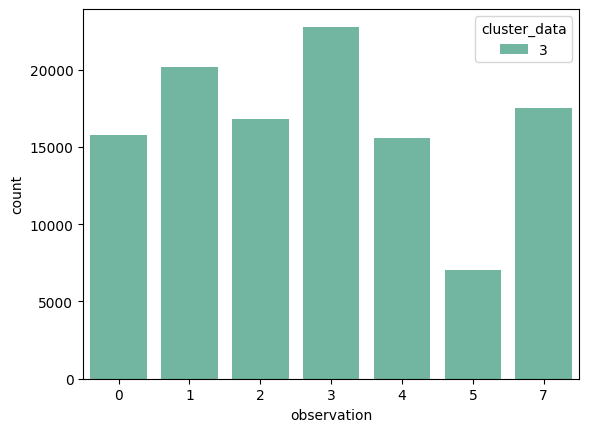

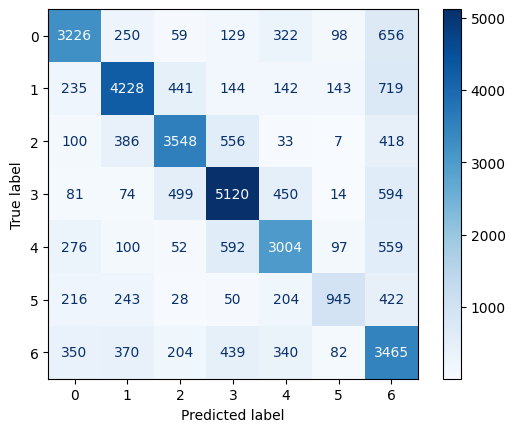

{'average_accuracy': 0.6757500926040253, 'average_f1_macro': np.float64(0.6608762792565408), 'average_f1_micro': np.float64(0.6757500926040253), 'average_auc': np.float64(0.9269508666722615), 'average_acc_kelas_generatif': 0.7008581603999725, 'average_acc_fase_padi': 0.7076536535420607}
{'val_accuracy': 0.6780754825698646, 'val_f1_macro': np.float64(0.6640448735760908), 'val_f1_micro': np.float64(0.6780754825698646), 'val_auc': np.float64(0.9276454444132906), 'val_acc_kelas_generatif': 0.7028526148969889, 'val_acc_fase_padi': 0.7110973888496824, 'val_relative_acc': np.float64(96.19911007610096)}
CLUSTER:  4


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 4 0 1 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      5438
           1       0.77      0.66      0.71      7305
           2       0.71      0.64      0.67      5273
           3       0.70      0.67      0.68      7875
           4       0.64      0.57      0.60      5032
           5       0.70      0.46      0.56      2497
           6       0.61      0.80      0.69     13358

    accuracy                           0.67     46778
   macro avg       0.69      0.63      0.65     46778
weighted avg       0.68      0.67      0.67     46778



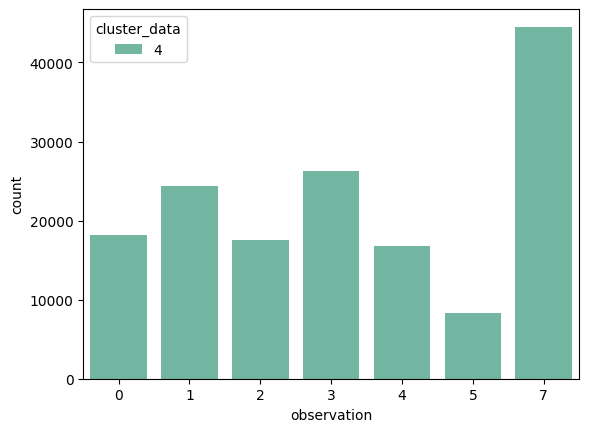

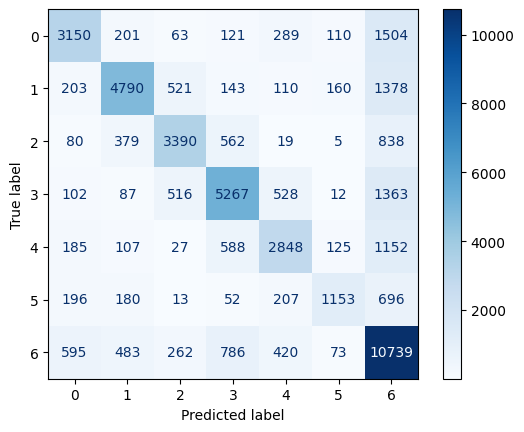

{'average_accuracy': 0.6718553953293775, 'average_f1_macro': np.float64(0.6523215860807502), 'average_f1_micro': np.float64(0.6718553953293775), 'average_auc': np.float64(0.9163294099192243), 'average_acc_kelas_generatif': 0.6506262904563218, 'average_acc_fase_padi': 0.6480491091598097}
{'val_accuracy': 0.6699089315490188, 'val_f1_macro': np.float64(0.6502209869422898), 'val_f1_micro': np.float64(0.6699089315490188), 'val_auc': np.float64(0.9153971099994193), 'val_acc_kelas_generatif': 0.6428977811492509, 'val_acc_fase_padi': 0.641033563786644, 'val_relative_acc': np.float64(96.4615257867853)}
CLUSTER:  5


/tmp/ipykernel_35797/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 7 5 4 3 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      2498
           1       0.84      0.72      0.77      4620
           2       0.79      0.72      0.76      3638
           3       0.79      0.77      0.78      4920
           4       0.71      0.67      0.69      3015
           5       0.80      0.53      0.64      1567
           6       0.65      0.87      0.75      6540

    accuracy                           0.75     26798
   macro avg       0.77      0.71      0.73     26798
weighted avg       0.76      0.75      0.74     26798



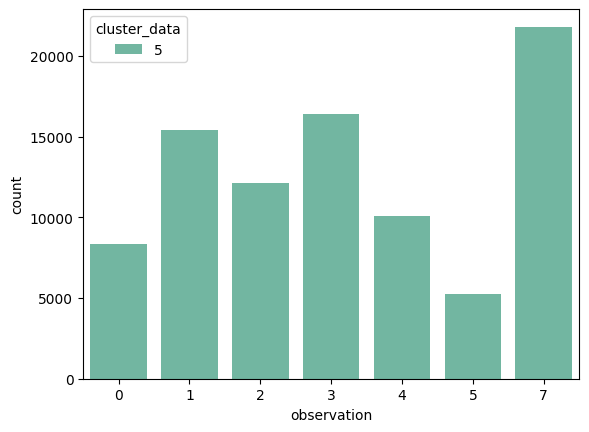

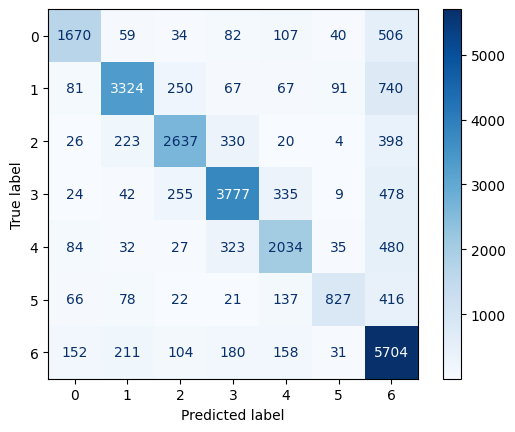

{'average_accuracy': 0.7464136315727987, 'average_f1_macro': np.float64(0.7313136248246971), 'average_f1_micro': np.float64(0.7464136315727987), 'average_auc': np.float64(0.9484805097542921), 'average_acc_kelas_generatif': 0.729583349817769, 'average_acc_fase_padi': 0.73363596925792}
{'val_accuracy': 0.7453168146876633, 'val_f1_macro': np.float64(0.7301454222491403), 'val_f1_micro': np.float64(0.7453168146876633), 'val_auc': np.float64(0.947998848964646), 'val_acc_kelas_generatif': 0.7248488180318856, 'val_acc_fase_padi': 0.7277366675172238, 'val_relative_acc': np.float64(97.35386549340038)}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
df=df.query('observation!=6')
dict_report={}
for i in [0,1,2,3,4,5]:
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    
    X_train_n=X_train.copy()
    cols=X_train.columns
    for index, rows in X_train.iterrows():
        mean=np.mean(rows)
        std=np.std(rows)
        for x in cols:
            X_train_n.at[index,x]=(rows[x]-mean)/std
    
    X_test_n=X_test.copy()
    for index, rows in X_test.iterrows():
        mean=np.mean(rows)
        std=np.std(rows)
        for x in cols:
            X_test_n.at[index,x]=(rows[x]-mean)/std
    
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Train and evaluate the model using the standardized features
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train_n, y_train_encoded, X_test_n, y_test_encoded)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)

In [11]:
import pickle
with open('/data/ksa/00_Code/07_Modeling/model/xgboost_recode2_standard.pkl','wb') as file:
    pickle.dump(dict_report,file)


### Running Data - Sampled

/tmp/ipykernel_35797/4073032696.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby(['observation','cluster_data'], group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))


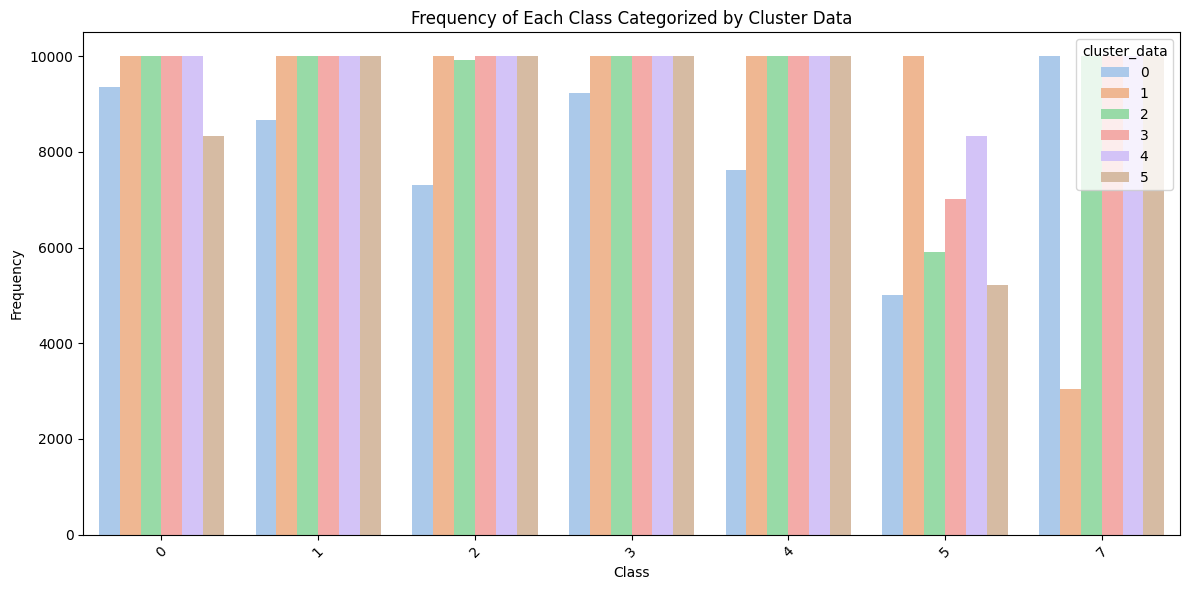

In [12]:
df_sampled = df.groupby(['observation','cluster_data'], group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))

class_counts_clustered = df_sampled.groupby(['observation', 'cluster_data']).size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_clustered, x='observation', y='counts', hue='cluster_data', palette='pastel')

plt.title('Frequency of Each Class Categorized by Cluster Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

CLUSTER:  0
[0 1 2 3 4 5 7]


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.74      0.78      2805
           1       0.92      0.87      0.89      2603
           2       0.85      0.83      0.84      2190
           3       0.84      0.81      0.82      2768
           4       0.81      0.81      0.81      2287
           5       0.92      0.77      0.84      1500
           6       0.68      0.86      0.76      3000

    accuracy                           0.81     17153
   macro avg       0.83      0.81      0.82     17153
weighted avg       0.82      0.81      0.82     17153



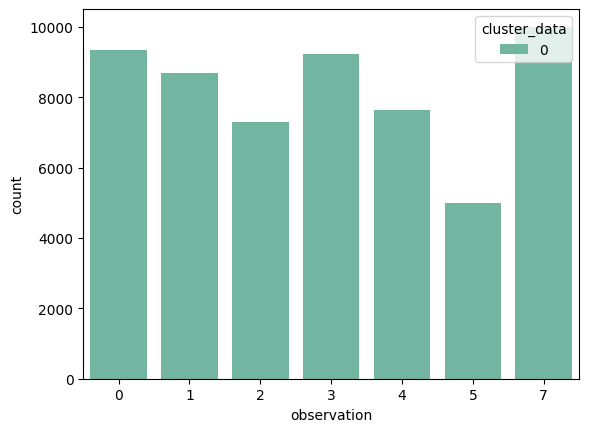

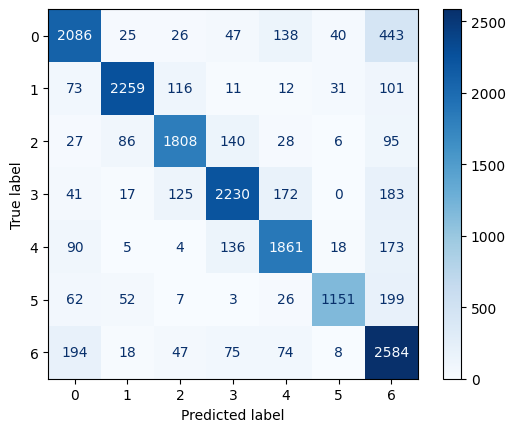

{'average_accuracy': 0.815126627816635, 'average_f1_macro': np.float64(0.818811889185444), 'average_f1_micro': np.float64(0.815126627816635), 'average_auc': np.float64(0.9733670919833483), 'average_acc_kelas_generatif': 0.8293542074363991, 'average_acc_fase_padi': 0.811652529550488}
{'val_accuracy': 0.8149594823063021, 'val_f1_macro': np.float64(0.8194909601200647), 'val_f1_micro': np.float64(0.8149594823063021), 'val_auc': np.float64(0.9737691038463713), 'val_acc_kelas_generatif': 0.8255707762557077, 'val_acc_fase_padi': 0.8087015242137758, 'val_relative_acc': np.float64(98.11467612211364)}
CLUSTER:  1


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3000
           1       0.93      0.90      0.92      3000
           2       0.88      0.89      0.89      3000
           3       0.87      0.87      0.87      3000
           4       0.86      0.87      0.87      3000
           5       0.91      0.91      0.91      3000
           6       0.72      0.73      0.73       915

    accuracy                           0.88     18915
   macro avg       0.86      0.87      0.86     18915
weighted avg       0.88      0.88      0.88     18915



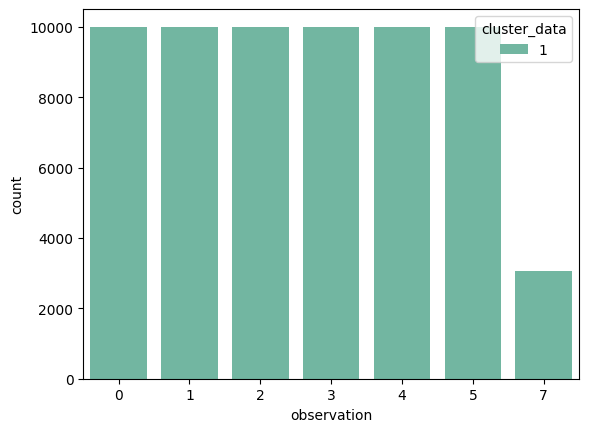

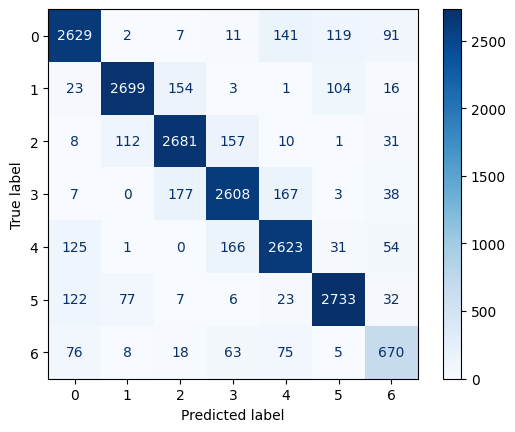

{'average_accuracy': 0.8758355047014842, 'average_f1_macro': np.float64(0.8634425089357242), 'average_f1_micro': np.float64(0.8758355047014842), 'average_auc': np.float64(0.988991212937331), 'average_acc_kelas_generatif': 0.89, 'average_acc_fase_padi': 0.8775000000000001}
{'val_accuracy': 0.8798836901929685, 'val_f1_macro': np.float64(0.8647126723790188), 'val_f1_micro': np.float64(0.8798836901929685), 'val_auc': np.float64(0.9894020667629203), 'val_acc_kelas_generatif': 0.8936666666666667, 'val_acc_fase_padi': 0.88475, 'val_relative_acc': np.float64(99.66923925027564)}
CLUSTER:  2


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3000
           1       0.84      0.75      0.79      3000
           2       0.79      0.81      0.80      2978
           3       0.83      0.79      0.81      3000
           4       0.77      0.82      0.80      3000
           5       0.78      0.70      0.74      1770
           6       0.67      0.75      0.71      3000

    accuracy                           0.78     19748
   macro avg       0.78      0.77      0.78     19748
weighted avg       0.78      0.78      0.78     19748



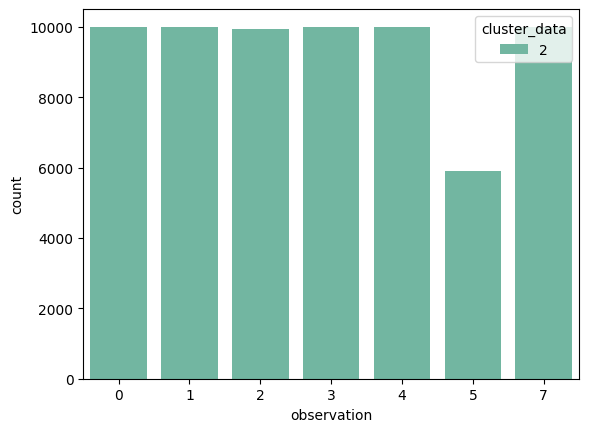

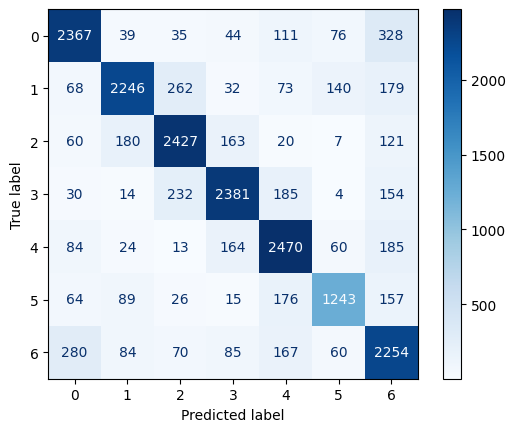

{'average_accuracy': 0.7777850100040695, 'average_f1_macro': np.float64(0.7761042521299769), 'average_f1_micro': np.float64(0.7777850100040695), 'average_auc': np.float64(0.9674784212934273), 'average_acc_kelas_generatif': 0.8065367662673317, 'average_acc_fase_padi': 0.7865960705461885}
{'val_accuracy': 0.7792181486732833, 'val_f1_macro': np.float64(0.7774844789188105), 'val_f1_micro': np.float64(0.7792181486732833), 'val_auc': np.float64(0.9683878025251157), 'val_acc_kelas_generatif': 0.8149764942914708, 'val_acc_fase_padi': 0.7865252963766906, 'val_relative_acc': np.float64(97.48615563975517)}
CLUSTER:  3


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      3000
           1       0.78      0.67      0.72      3000
           2       0.74      0.74      0.74      3000
           3       0.70      0.70      0.70      3000
           4       0.67      0.71      0.69      3000
           5       0.68      0.61      0.64      2108
           6       0.58      0.70      0.63      3000

    accuracy                           0.69     20108
   macro avg       0.70      0.69      0.69     20108
weighted avg       0.70      0.69      0.70     20108



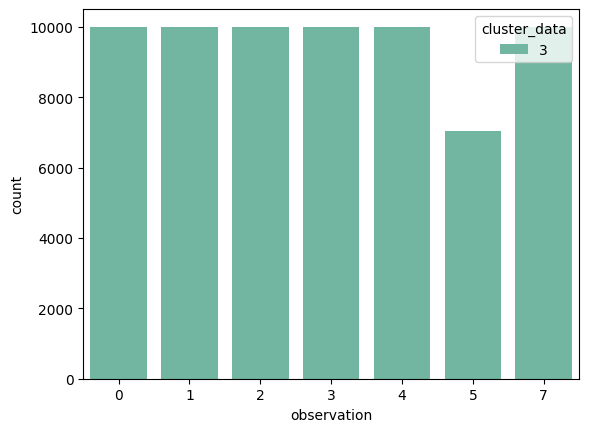

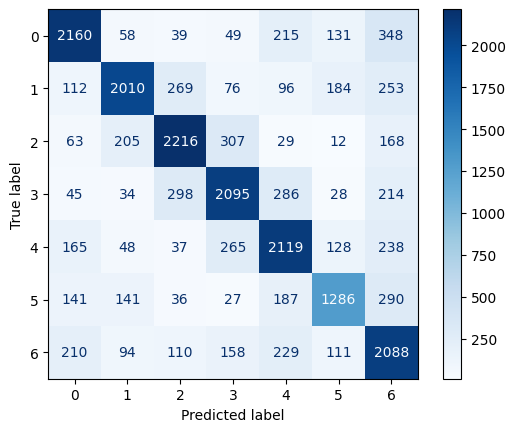

{'average_accuracy': 0.7024958571300203, 'average_f1_macro': np.float64(0.701661854589658), 'average_f1_micro': np.float64(0.7024958571300203), 'average_auc': np.float64(0.9394759304191795), 'average_acc_kelas_generatif': 0.7545714285714287, 'average_acc_fase_padi': 0.7166785714285715}
{'val_accuracy': 0.6949472846628207, 'val_f1_macro': np.float64(0.6937924237655221), 'val_f1_micro': np.float64(0.6949472846628207), 'val_auc': np.float64(0.9381247947386547), 'val_acc_kelas_generatif': 0.7386666666666667, 'val_acc_fase_padi': 0.70675, 'val_relative_acc': np.float64(96.11913357400722)}
CLUSTER:  4


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      3000
           1       0.77      0.65      0.70      3000
           2       0.72      0.73      0.73      3000
           3       0.68      0.67      0.67      3000
           4       0.67      0.64      0.66      3000
           5       0.71      0.66      0.69      2498
           6       0.55      0.72      0.62      3000

    accuracy                           0.68     20498
   macro avg       0.69      0.68      0.68     20498
weighted avg       0.69      0.68      0.68     20498



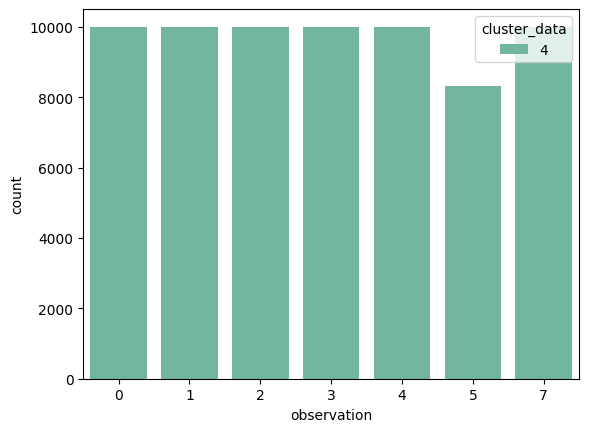

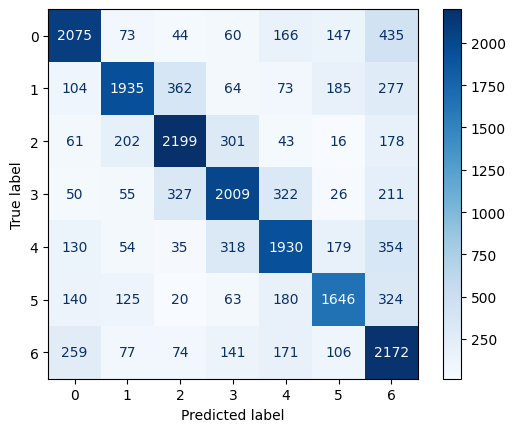

{'average_accuracy': 0.6851360220173404, 'average_f1_macro': np.float64(0.6871578573120993), 'average_f1_micro': np.float64(0.6851360220173404), 'average_auc': np.float64(0.9337766283365141), 'average_acc_kelas_generatif': 0.7291428571428572, 'average_acc_fase_padi': 0.6876428571428571}
{'val_accuracy': 0.6813347643672554, 'val_f1_macro': np.float64(0.6829476354623661), 'val_f1_micro': np.float64(0.6813347643672554), 'val_auc': np.float64(0.9332243093576619), 'val_acc_kelas_generatif': 0.733, 'val_acc_fase_padi': 0.6848333333333333, 'val_relative_acc': np.float64(95.85129310344827)}
CLUSTER:  5
[0 1 2 3 4 5 7]


/tmp/ipykernel_35797/2758052433.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(7): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2497
           1       0.84      0.74      0.79      3000
           2       0.82      0.80      0.81      3000
           3       0.81      0.75      0.78      3000
           4       0.75      0.80      0.77      3000
           5       0.78      0.61      0.68      1568
           6       0.69      0.83      0.75      3000

    accuracy                           0.78     19065
   macro avg       0.78      0.77      0.77     19065
weighted avg       0.78      0.78      0.78     19065



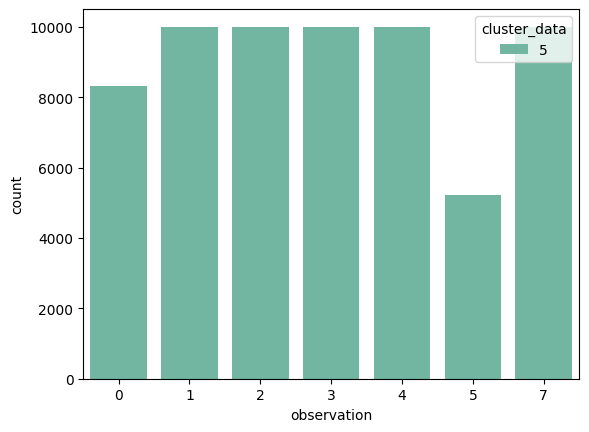

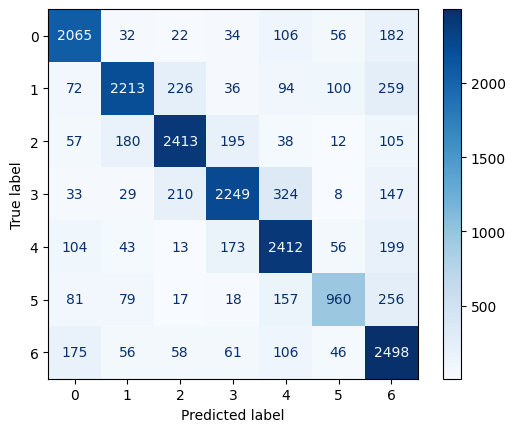

{'average_accuracy': 0.7758795099471734, 'average_f1_macro': np.float64(0.7707566730193278), 'average_f1_micro': np.float64(0.7758795099471734), 'average_auc': np.float64(0.9643404113878716), 'average_acc_kelas_generatif': 0.8071428571428572, 'average_acc_fase_padi': 0.7783655538531064}
{'val_accuracy': 0.7768161552583268, 'val_f1_macro': np.float64(0.7710862491978931), 'val_f1_micro': np.float64(0.7768161552583268), 'val_auc': np.float64(0.9637965728103409), 'val_acc_kelas_generatif': 0.8043333333333333, 'val_acc_fase_padi': 0.7775941549969557, 'val_relative_acc': np.float64(97.01637628056532)}


In [15]:
df_sampled['observation']=df_sampled['observation'].apply(lambda y: int(y))
df_sampled=df_sampled.query('observation!=6')
dict_report={}
for i in [0,1,2,3,4,5]:
    print('CLUSTER: ', i)
    df_x = df_sampled.query('cluster_data==@i')
    
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    
    # X_train_n=X_train.copy()
    # cols=X_train.columns
    # for index, rows in X_train.iterrows():
    #     mean=np.mean(rows)
    #     std=np.std(rows)
    #     for x in cols:
    #         X_train_n.at[index,x]=(rows[x]-mean)/std
    
    # X_test_n=X_test.copy()
    # for index, rows in X_test.iterrows():
    #     mean=np.mean(rows)
    #     std=np.std(rows)
    #     for x in cols:
    #         X_test_n.at[index,x]=(rows[x]-mean)/std
    
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Train and evaluate the model using the standardized features
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)

In [17]:
import pickle
with open('/data/ksa/00_Code/07_Modeling/model/xgboost_recode2_sampling_wo_standard.pkl','wb') as file:
    pickle.dump(dict_report,file)

In [16]:
1+4

5

## Predict on Testing Data

In [18]:
import pickle
with open('/data/ksa/00_Code/07_Modeling/model/xgboost_recode2_sampling_wo_standard.pkl','rb') as file:
    dict_report = pickle.load(file)

# dict_report

In [19]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [20]:
testing  = pd.read_pickle('/data/ksa/04_Data_Preprocessing/training-test/32/testing_imputation_32_VH_recode2.pkl')
cluster  = gpd.read_file('../../00_Data_Input/cluster_data/cluster_32_ok.gpkg')

In [21]:
var_ = list(df.loc[:,'VH_30':'VH_0'].columns.values) + ['nth']
# var_

In [22]:
testing['idkab'] = testing['idpoint'].str[:4]
testing = testing.merge(cluster[['idkab','cluster_data']], how='right', on='idkab')
testing = testing.dropna()

testing.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,year,date,idkab,cluster_data
0,320130009A1#01,320130009A1,320130009,10,2023_25,BP,48MXU,-16.725023,-17.835718,-18.861912,...,-16.753235,-15.073020,-12.567095,-15.945707,-19.707195,-14.096098,23,2023-10-01,3201,0
1,320130009A1#02,320130009A1,320130009,10,2023_25,BP,48MXU,-17.029100,-18.132090,-19.203442,...,-16.679087,-15.764339,-13.903972,-16.411623,-19.349918,-14.618581,23,2023-10-01,3201,0
2,320130009A1#03,320130009A1,320130009,10,2023_25,BP,48MXU,-16.883081,-18.095416,-19.142895,...,-17.516607,-15.456612,-12.541103,-15.449263,-17.949583,-15.539997,23,2023-10-01,3201,0
3,320130009A1#04,320130009A1,320130009,10,2023_25,BP,48MXU,-16.310753,-17.412438,-18.193932,...,-17.875544,-15.436776,-12.406763,-15.630909,-18.461334,-15.473708,23,2023-10-01,3201,0
4,320130009A1#05,320130009A1,320130009,10,2023_25,BP,48MXU,-16.897139,-17.672377,-18.074509,...,-18.206902,-16.664985,-14.854314,-16.607943,-17.888708,-16.222599,23,2023-10-01,3201,0


In [23]:
conditions = {
    'V1':1,
    'V2':2,
    'G':3,
    'H':4,
    'BP':0,
    'PL':5,
    'BPL':0,
    'NP':6,
    'NV':6
}

# Mapping values in 'column_name'
testing['obs_ste'] = testing['observation']
testing['observation'] = testing['obs_ste'].map(conditions)

In [33]:
def model_utilization(data, Y_var, X_vars, iterasi, Category, dict_report):
    db = pd.DataFrame()
    for idx in range(0,6):
        tpt = data.loc[data[iterasi]==idx]
        dtest = xgb.DMatrix(tpt[X_vars], enable_categorical=True)
        model_ = dict_report[idx]['model']
        Y_pred_prob = model_.predict(dtest)
        Y_pred = Y_pred_prob.argmax(axis=1)
        tpt['Y_pred'] = Y_pred
        tpt['observation'] = tpt[Y_var]
        db = pd.concat([db,tpt])
        
    list_district = list(db[Category].unique())
    result = []
    
    for i in list_district:
        temp = db.loc[db[Category] == i]
        res_temp = {}
        cm = confusion_matrix(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['district'] = i
        res_temp['accuracy'] = accuracy_score(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['precision'] = precision_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['recall'] = recall_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['f1_macro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='macro')
        res_temp['f1_micro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='micro')
        n = cm.shape[0]
        res_temp['racc_before'] = sum(cm[i, (i+1) % n] for i in range(n)) / cm.sum()
        res_temp['racc_after'] = sum(cm[(i+1) % n, i] for i in range(n)) / cm.sum()

        if '3' in temp.loc[:,Y_var].astype(str).unique():
            class_3_index = temp[Y_var].astype(str) == '3'
            res_temp['accuracy_class_3.0'] = accuracy_score(temp[Y_var][class_3_index], temp['Y_pred'][class_3_index])
        else:
            res_temp['accuracy_class_3.0'] = None   

        result.append(res_temp)
        # break
    
    result_df = pd.DataFrame(result)
    
    return db, result_df

In [34]:
db, result_df = model_utilization(testing, 'observation', var_, 'cluster_data', 'idkab', dict_report)

In [ ]:
list_district = list(db['idkab'].unique())
result = []

Y_var = 'idkab'
for i in tqdm(list_district):
    temp = db.loc[db['idkab'] == i]
    res_temp = {}
    cm = confusion_matrix(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str))
    res_temp['district'] = i
    res_temp['accuracy'] = accuracy_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str))
    res_temp['precision'] = precision_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    res_temp['recall'] = recall_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    res_temp['f1_macro'] = f1_score(temp[Y_var].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='macro')
    res_temp['f1_micro'] = f1_score(temp[Y_var].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    n = cm.shape[0]
    res_temp['racc_before'] = sum(cm[i, (i+1) % n] for i in range(n)) / cm.sum()
    res_temp['racc_after'] = sum(cm[(i+1) % n, i] for i in range(n)) / cm.sum()

    if '3.0' in temp.loc[:,Y_var].astype(float).astype(str).unique():
        class_3_index = temp[Y_var].astype(str) == '3'
        res_temp['accuracy_class_3.0'] = accuracy_score(temp[Y_var][class_3_index], temp['Y_pred'][class_3_index])
    else:
        res_temp['accuracy_class_3.0'] = None   

    result.append(res_temp)
    # break
    
result_df2 = pd.DataFrame(result)
result_df2

In [63]:
result_df2.sort_values('district')

,district,accuracy,precision,recall,f1_macro,f1_micro,racc_before,racc_after,accuracy_class_3.0
0,3201,0.443189,0.443189,0.443189,0.0,0.0,0.065935,0.065594,None
17,3202,0.280596,0.280596,0.280596,0.0,0.0,0.136283,0.052080,None
18,3203,0.304373,0.304373,0.304373,0.0,0.0,0.122103,0.077580,None
21,3204,0.371605,0.371605,0.371605,0.0,0.0,0.100362,0.083195,None
19,3205,0.317241,0.317241,0.317241,0.0,0.0,0.124785,0.080647,None
11,3206,0.338335,0.338335,0.338335,0.0,0.0,0.107407,0.079924,None
12,3207,0.300042,0.300042,0.300042,0.0,0.0,0.125577,0.052146,None
13,3208,0.227207,0.227207,0.227207,0.0,0.0,0.159290,0.061867,None
8,3209,0.426861,0.426861,0.426861,0.0,0.0,0.087690,0.056378,None
9,3210,0.353977,0.353977,0.353977,0.0,0.0,0.118860,0.050570,None


In [56]:
# f1_score(temp[Y_var].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='macro')

In [47]:
list_district = [0,1,2,3,4,5,6]
result = []

Y_var = 'observation'
for i in list_district:
    temp = db.loc[db['cluster_data'] == i]
    res_temp = {}
    cm = confusion_matrix(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str))
    res_temp['district'] = i
    res_temp['accuracy'] = accuracy_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str))
    res_temp['precision'] = precision_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    res_temp['recall'] = recall_score(temp['observation'].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    res_temp['f1_macro'] = f1_score(temp[Y_var].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='macro')
    res_temp['f1_micro'] = f1_score(temp[Y_var].astype(float).astype(str), temp['Y_pred'].astype(float).astype(str), average='micro')
    n = cm.shape[0]
    res_temp['racc_before'] = sum(cm[i, (i+1) % n] for i in range(n)) / cm.sum()
    res_temp['racc_after'] = sum(cm[(i+1) % n, i] for i in range(n)) / cm.sum()

    if '3.0' in temp.loc[:,Y_var].astype(str).unique():
        class_3_index = temp[Y_var].astype(str) == '3'
        res_temp['accuracy_class_3.0'] = accuracy_score(temp[Y_var][class_3_index], temp['Y_pred'][class_3_index])
    else:
        res_temp['accuracy_class_3.0'] = None   

    result.append(res_temp)
    # break
    
result_df2 = pd.DataFrame(result)
result_df2

/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/data/home/novia.permatasari/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:138

,district,accuracy,precision,recall,f1_macro,f1_micro,racc_before,racc_after,accuracy_class_3.0
0,0,0.459652,0.459652,0.459652,0.307766,0.459652,0.085218,0.059480,NaN
1,1,0.500642,0.500642,0.500642,0.387498,0.500642,0.105945,0.049263,NaN
2,2,0.390554,0.390554,0.390554,0.248003,0.390554,0.100888,0.054289,NaN
3,3,0.293927,0.293927,0.293927,0.215101,0.293927,0.123019,0.067904,NaN
4,4,0.301606,0.301606,0.301606,0.209136,0.301606,0.128160,0.069039,NaN
5,5,0.368264,0.368264,0.368264,0.255026,0.368264,0.103667,0.068356,NaN
6,6,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN


In [46]:
temp.loc[:,Y_var].astype(str).unique()

array(['0.0', '6.0', '5.0', '4.0', '2.0', '3.0', '1.0', 'nan'],
      dtype=object)

In [29]:
# confusion_matrix(db['observation'].astype(str), db['Y_pred'].astype(str))
confusion_matrix(db[['observation']].astype(float).astype(str), db[['Y_pred']].astype(float).astype(str))

array([[153104,  97916,  54303,  52752,  37239,  64949,  72662,      0],
       [  9802,  52215,   9437,   6133,   7069,  19800,  19369,      0],
       [  5785,  14901,  20571,   7234,   1977,   3277,   9080,      0],
       [  9815,   6443,  11810,  41089,  18413,   6986,  14519,      0],
       [ 22596,   4704,   1678,   9965,  48757,  11506,  12719,      0],
       [ 23916,  29813,  17946,  17473,  18189,  30335,  22178,      0],
       [ 46901,  45737,  21876,  18242,  21491,  28314, 221114,      0],
       [  2321,   2993,   1197,   1300,   1385,   1125,   2004,      0]])

In [71]:
db2 = db.dropna(subset='observation')
confusion_matrix(db2[['observation']].astype(float).astype(str), db2[['Y_pred']].astype(float).astype(str))

array([[153104,  97916,  54303,  52752,  37239,  64949,  72662],
       [  9802,  52215,   9437,   6133,   7069,  19800,  19369],
       [  5785,  14901,  20571,   7234,   1977,   3277,   9080],
       [  9815,   6443,  11810,  41089,  18413,   6986,  14519],
       [ 22596,   4704,   1678,   9965,  48757,  11506,  12719],
       [ 23916,  29813,  17946,  17473,  18189,  30335,  22178],
       [ 46901,  45737,  21876,  18242,  21491,  28314, 221114]])

In [ ]:
data = testing.copy()
idx = 0
iterasi = 'cluster_data'
model_ = dict_report[0]['model']
X_vars = var_
Y_var = 'observation'

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [ ]:
tpt = data.loc[data[iterasi]==idx]
dtest = xgb.DMatrix(tpt[X_vars], enable_categorical=True)
Y_pred_prob = model_.predict(dtest)
Y_pred = Y_pred_prob.argmax(axis=1)

In [ ]:
tpt['Y_pred'] = Y_pred
tpt['observation'] = tpt[Y_var]
db = pd.concat([db,tpt])

In [ ]:
tpt = data.loc[data[iterasi]==idx]
model_ = dict_report[idx]['model']
Y_pred = model_.predict(tpt[X_vars])
tpt['Y_pred'] = Y_pred
tpt['observation'] = tpt[Y_var]
db = pd.concat([db,tpt])

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [ ]:
dict_report[0]['model']